<a href="/assets/tutorial07_example.ipynb" class="link-button">Download</a>
<a href="https://colab.research.google.com/github/technion046195/technion046195/blob/master/content/tutorial10/example.ipynb" target="_blank">
<img src="../assets/colab-badge.svg" style="display:inline"/>
</a>

<center><h1>
תרגול 10 - דוגמא מעשית
</h1></center>

## Setup

In [ ]:
## Importing packages
import os # A build in package for interacting with the OS. For example to create a folder.
import numpy as np  # Numerical package (mainly multi-dimensional arrays and linear algebra)
import pandas as pd  # A package for working with data frames
import matplotlib.pyplot as plt  # A plotting package
import imageio  # A package to read and write image (is used here to save gif images)
import tabulate  # A package from pretty printing tables
from graphviz import Digraph  # A package for plothing graphs (of nodes and edges)
import torch  ## importing PyTorch
import torch.optim as optim  ## Import the optimization module of the package
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import tqdm.notebook as tqdm

## Setup matplotlib to output figures into the notebook
## - To make the figures interactive (zoomable, tooltip, etc.) use ""%matplotlib notebook" instead
%matplotlib inline

## Setting some nice matplotlib defaults
plt.rcParams['figure.figsize'] = (4.5, 4.5)  # Set default plot's sizes
plt.rcParams['figure.dpi'] = 120  # Set default plot's dpi (increase fonts' size)
plt.rcParams['axes.grid'] = True  # Show grid by default in figures

## Auxiliary function for prining equations, pandas tables and images in cells output
from IPython.core.display import display, HTML, Latex, Markdown

## Create output folder
if not os.path.isdir('./output'):
    os.mkdir('./output')

## Downloading and Loading the Dataset
We will start by loading the data and looking at it's properties.

The data can be easily downloaded and loaded using the *torchvision* command [torchvision.datasets.MNIST](https://pytorch.org/docs/stable/torchvision/datasets.html#mnist)

In [ ]:
# MNIST dataset
train_full_set = torchvision.datasets.MNIST(root='./data/mnist',
                                            train=True, 
                                            transform=transforms.ToTensor(),
                                            download=True)

test_set = torchvision.datasets.MNIST(root='./data/mnist',
                                      train=False, 
                                      transform=transforms.ToTensor())

n_samples_val = 1024
train_set, val_set = torch.utils.data.random_split(train_full_set,
                                                   [len(train_full_set) - n_samples_val, n_samples_val],
                                                   generator=torch.Generator().manual_seed(42))

# Data Loader
batch_size = 64

train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=batch_size)

x_val, y_val = zip(*[val_set[i] for i in range(len(val_set))])
x_val = torch.stack(x_val, dim=0)
y_val = torch.tensor(y_val)

### The Dataset Properties
Let us print the properties of the dataset along with the first few images

Number of rows in the train dataset: N=60000
Number of rows in the test dataset: N=10000
Image size: 28x28
Pixel's value range: [0.0, 0.9960784316062927]


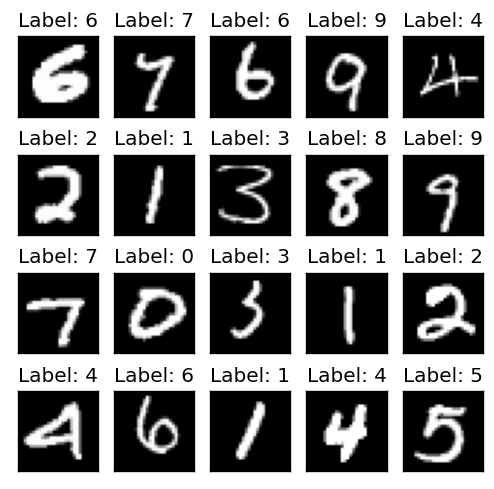

In [ ]:
fig, ax_array = plt.subplots(4, 5, figsize=(5, 5))
for i, ax in enumerate(ax_array.flat):
    img, label = train_set[i]
    ax.imshow(img[0].numpy(), cmap='gray')
    ax.set_title('Label: {}'.format(label))
    ax.set_yticks([])
    ax.set_xticks([])

print(f'Number of rows in the train dataset: N={len(train_full_set)}')
print(f'Number of rows in the test dataset: N={len(test_set)}')

print(f'Image size: {img.shape[1]}x{img.shape[2]}')
print(f'Pixel\'s value range: [{img.min()}, {img.max()}]')

fig.savefig('./output/mnist.png', dpi=240)

### The Network

In [ ]:
class LeNet5(nn.Module):
     
    def __init__(self):   
        super(LeNet5, self).__init__()
        
        ## Defining the layers
        ## =========================================================
        ## C1: Convolutional layer: kernel size=5x5, output channels=6.
        ## Here we will add the padding of 2 to make the images of MNIST fit to the network.
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2)
        self.relu1 = torch.nn.ReLU()  

        ## S2: Max pooling layer: size=2x2, stride=2
        self.max_pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)

        ## C3: Convolutional layer + ReLU activation: kernel size=5x5, output channels=16.
        self.conv3 = torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.relu3 = torch.nn.ReLU()
        
        ## S4: Max pooling layer: size=2x2, stride=2vector)
        self.max_pool4 = torch.nn.MaxPool2d(kernel_size=2, stride=2)

        ## C5: Convolutional layer + ReLU activation: kernel size=5x5, output channels=120.
        self.conv5 = torch.nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5)
        self.relu5 = torch.nn.ReLU()

        ## F6: Fully connected layer + ReLU: output vector length=84
        self.fc6 = torch.nn.Linear(120, 84)
        self.relu6 = torch.nn.ReLU()
        
        ## Output: Fully connected layer + ReLU: output vector length=10
        self.fc_output = torch.nn.Linear(84, 10)

        ## Note: It is not actually necessary to define multiple ReLUs and max-pooling operations
        ## since these layers have no parameters.
        
        
    def forward(self, x):
        ## C1: Convolutional layer + ReLU activation: kernel size=5x5, output channels=6.
        x = self.conv1(x)
        x = self.relu1(x)
        
        ## S2: Max pooling layer: size=2x2, stride=2
        x = self.max_pool2(x)

        ## C3: Convolutional layer + ReLU activation: kernel size=5x5, output channels=16.
        x = self.conv3(x)
        x = self.relu3(x)

        ## S4: Max pooling layer: size=2x2, stride=2
        x = self.max_pool4(x)

        ## C5: Convolutional layer + ReLU activation: kernel size=5x5, output channels=120.
        x = self.conv5(x)
        x = self.relu5(x)

        x = x.view(x.shape[0], x.shape[1]) ## Redefine x as a 1D vector
        
        ## F6: Fully connected layer + ReLU: output vector length= 84
        x = self.fc6(x)
        x = self.relu6(x)

        ## Output layer: Fully connected layer: output vector length=10
        x = self.fc_output(x)
        
        return x

### Learning

In [ ]:
def train(net, eta, n_epoch, train_loader, x_val, y_val, run_validation_every=100, device_id='cpu'):
    
    x_val = x_val.to(device_id)
    y_val = y_val.to(device_id)
    
    ## Set the objective
    objective_func = torch.nn.CrossEntropyLoss()
    
    ## Initizalie the optimizer
    optimizer = torch.optim.SGD(net.parameters(), lr=eta)

    ## Perforing the update steps
    train_objective_list = []
    val_objective_list = []
    val_steps = []
    
    step = 0
    for epoch in tqdm.tqdm(range(n_epoch), leave=False):
        for x, y in tqdm.tqdm(train_loader, leave=False):
            if step % run_validation_every == 0:
                with torch.no_grad():
                    py_hat = net(x_val)
                    objective = objective_func(py_hat, y_val)
                    val_objective_list.append(objective.item())
                    val_steps.append(step)

            x = x.to(device_id)
            y = y.to(device_id)

            optimizer.zero_grad()
            ## Forward pass
            py_hat = net(x)
            objective = objective_func(py_hat, y)
            ## Backward pass
            objective.backward()
            ## Preform the gradient descent step
            optimizer.step()
            step += 1

            train_objective_list.append(objective.item())
    
    return train_objective_list, val_objective_list, val_steps

/usr/local/lib/python3.6/dist-packages/torch/autograd/__init__.py:132: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  allow_unreachable=True)  # allow_unreachable flag


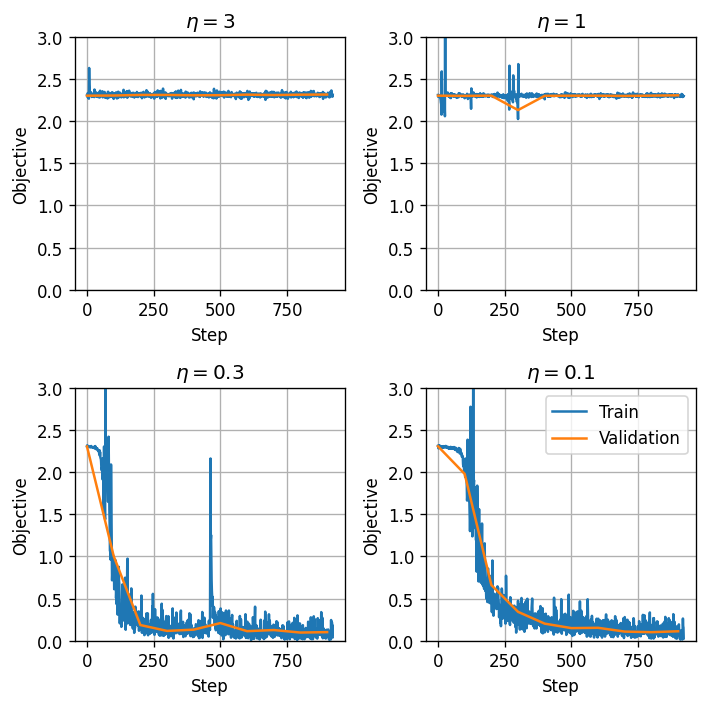

In [ ]:
device_id = 'cpu'  # 'cuda:0'

n_epoch = 1
run_validation_every = 100
etas_list = (3, 1e0, 3e-1, 1e-1)

# iters_list = np.arange(0, n_iters + 1)

fig, axes = plt.subplots(2, 2, figsize=(6, 6))
for i_eta, eta in enumerate(etas_list):
    net = LeNet5()
    net = net.to(device_id)

    train_objective_list, val_objective_list, val_steps = train(net, eta, n_epoch, train_loader, x_val, y_val, run_validation_every, device_id)
    
    ## Plot
    ax = axes.flat[i_eta]
    ax.plot(np.arange(len(train_objective_list)), train_objective_list, label='Train')
    ax.plot(val_steps, val_objective_list, label='Validation')
    ax.set_title(r'$\eta={' + f'{eta:g}' + r'}$')
    ax.set_xlabel('Step')
    ax.set_ylabel('Objective')
axes[0,0].set_ylim(0, 3)
axes[0,1].set_ylim(0, 3)
axes[1,0].set_ylim(0, 3)
axes[1,1].set_ylim(0, 3)
axes[1,1].legend()
fig.tight_layout()
fig.savefig('./output/mnist_lenet_select_eta.png', dpi=240)

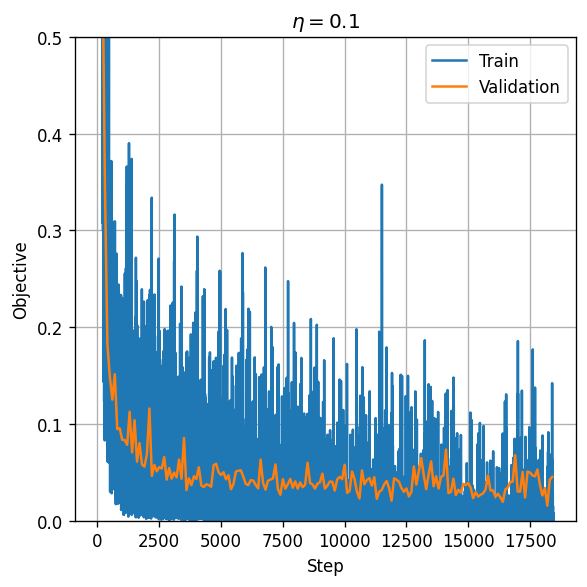

In [ ]:
alpha = 3e-1
n_epoch = 20

net = LeNet5()
net = net.to(device_id)

train_objective_list, val_objective_list, val_steps = train(net, eta, n_epoch, train_loader, x_val, y_val, run_validation_every, device_id)

## Plot
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(np.arange(len(train_objective_list)), train_objective_list, label='Train')
ax.plot(val_steps, val_objective_list, label='Validation')
ax.set_title(r'$\eta={' + f'{eta:g}' + r'}$')
ax.set_xlabel('Step')
ax.set_ylabel('Objective')
ax.set_ylim(0, 0.5)
ax.legend()
fig.tight_layout()
fig.savefig('./output/mnist_lenet_train.png', dpi=240)

In [ ]:
## Evaluate the score on the test set
with torch.no_grad():
    test_score_list = []
    for x, y in test_loader:
        x = x.to(device_id)
        y = y.to(device_id)

        y_hat = net(x)
        test_score = (torch.argmax(y_hat, dim=1) != y).sum()

        test_score_list.append(test_score.item())

test_score = np.sum(test_score_list) / len(test_set)

print(f'The test score is: {test_score:.2}')

The test score is: 0.011


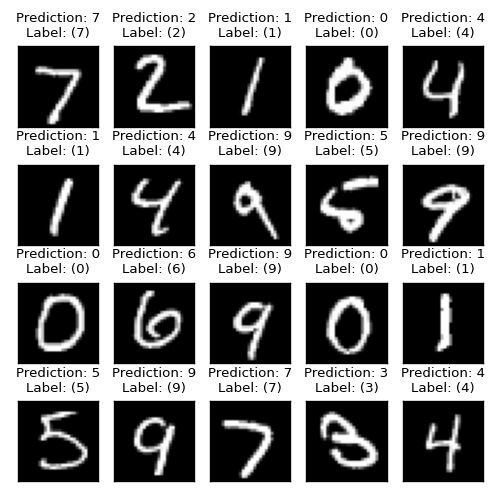

In [ ]:
fig, ax_array = plt.subplots(4, 5, figsize=(5, 5))
for i, ax in enumerate(ax_array.flat):
    x, y = test_set[i]
    with torch.no_grad():
        y_hat = int(torch.argmax(net(x[None, :])))
    ax.imshow(x[0].numpy(), cmap='gray')
    ax.set_title('Prediction: {}\nLabel: ({})'.format(y_hat, y), fontsize=8, color='black' if y_hat == y else 'red')
    ax.set_yticks([])
    ax.set_xticks([])
fig.savefig('./output/mnist_lenet_predictions.png', dpi=240)